# **2D Denoising pipeline**
___  
  
In this notebook, we demonstrate the use of the [BiaPy](https://biapyx.github.io/) pipeline for  **2D denoising** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/denosing_overview.svg' width='500px'/>
<figcaption><b>Figure 1</b>: Example of a 2D denoising problem.</figcaption></center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://biapyx.github.io/). Thank you!

## **Expected Inputs and Outputs**
___

### **Inputs**

This notebook expects the following folders as input:

1. **Training Raw Images**: Contains the raw 2D images used for training the model.
2. **Test Raw Images**: Houses the raw 2D images for testing the model.
3. **Output Folder**: A designated path where the denoised results will be saved.

## **Outputs**

Upon successful execution, a new folder will be generated, housing the denoising results. The resulting denoised files can be easily downloaded at the end of this notebook.

<font color='red'><b>Note:</b></font> For testing purposes, you can utilize the **example datasets provided under 'Manage File(s) Source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
├── train   
│   ├── training-0001.tif
│   ├── training-0002.tif
│   ├── . . .
│   └── training-9999.tif
└── test
    ├── testing-0001.tif
    ├── testing-0002.tif
    ├── . . .
    └── testing-9999.tif
```

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).


## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.



### **Option 1: Upload Local Files to the Notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train
%cd /content/input/train
uploaded = files.upload()
%cd /content

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/test
%cd /content/input/test
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.

Specifically, we'll use an image sourced from [Noise2Void](https://github.com/juglab/n2v). Specifically, it's an image of C. majalis captured by Britta Schroth-Diez from the MPI-CBG Light Microscopy Facility.

In [ ]:
#@markdown ##Play to download an example dataset
!pip install gdown==4.7.3 --quiet
import gdown
import os

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=1TFvOySOiIgVIv9p4pbHdEbai-d2YGDvV", "convallaria2D.zip", quiet=True)

!unzip -q convallaria2D.zip
!rm convallaria2D.zip

print('Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path` to `/content/input/train`
  - Set `test_data_path` to `/content/input/test`
  - Set `output_path` to `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path` to `/content/data/train`
  - Set `test_data_path` to `/content/data/test`
  - Set `output_path` to `/content/out`

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/data/train' #@param {type:"string"}
#@markdown #####Path to test images
test_data_path = '/content/data/test' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output

!pip install biapy==3.3.15

# Uninstall some packages already installed in Colab for Pytorch 2.1.0
!pip uninstall -y torchdata torchtext

# Then install Pytorch + CUDA 11.8
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118
!pip install 'timm>=0.9.12' 'torchmetrics>=1.3.0.post0'

from biapy import BiaPy

changed_source = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

## **Configure and train the DNN model**
[BiaPy](https://biapy.readthedocs.io/en/latest/) contains a few deep learning models to perform denoising with [Noise2Void](https://github.com/juglab/n2v) approach.

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.



In [ ]:
#@markdown ###Play to select the source to build the model (BiaPy or BioImage Model Zoo) { run: "auto", vertical-output: true, display-mode: "form" }
changed_source = True
exists_bmz = False

# create widgets
source = widgets.ToggleButtons(
    options=['BiaPy', 'BioImage Model Zoo'],
    description='Source:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Models created during this workflow', 'BioImage Model Zoo model'],
#     icons=['check'] * 3
)

bmz = widgets.Text(
    # value='10.5281/zenodo.5764892',
    placeholder='DOI of BMZ model',
    description='DOI:',
    disabled=False
)

# display the first widget
display(source)

# intialize the output - second widget
out = Output()

def changed(change):
    '''
    Monitor change in the first widget
    '''
    global out
    global exists_bmz
    # global exists_tv
    if source.value == 'BiaPy':
        bmz.layout.display = 'none'
        out.clear_output() #clear output
        out = Output() # redefine output
    else:
        bmz.layout.display = 'none'
        bmz.layout.display = 'flex'
        if not exists_bmz:
          out.append_display_data(bmz)
          display(out)
        exists_bmz = True

# monitor the source widget for changes
source.observe(changed, 'value')

ToggleButtons(description='Source:', options=('BiaPy', 'BioImage Model Zoo'), tooltips=('Models created during…

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 100**

* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: U-Net, Residual U-Net, ResUNet++, Attention U-Net and SEUNet [(see Franco-Barranco et al., 2021)](https://link.springer.com/article/10.1007/s12021-021-09556-1). **Default value: U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 48**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 64**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization. **Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.0001**

* **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: None**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

#### **Noise2Void parameters**
* **`n2v_perc_pix`:**  The fraction of pixels manipulated per each patch used for training. For instances, 0.198% of the input pixels per patch or a patch size of 64 by 64 pixels corresponds to about 8 pixels. **Default value: 0.198**

* **`pixel_manipulator:`** Controls how the pixels are going to be manipulated to train the network. **Default value: uniform_withCP**

* **`neighborhood_radius`:** Size of the neighborhood to compute the replacement. **Default value: 5**

* **`apply_structmask`:** Wheter to apply a structured mask as is proposed in [Noise2Void](https://github.com/juglab/n2v) to alleviate the limitation of the method of not removing efectively the structured noise (section 4.4 of their paper). **Default value: True**


In [ ]:
#@markdown ###Name of the model:
model_name = "my_2d_denoising" #@param {type:"string"}

#@markdown ### Basic training parameters:
number_of_epochs =  100#@param {type:"number"}
percentage_validation =  10 #@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:
model_architecture = "U-Net" #@param ["U-Net", "Residual U-Net", "Attention U-Net", 'ResUNet++', 'SEUNet']
batch_size =  48#@param {type:"number"}
patch_size = 64 #@param {type:"number"}
input_channels = 1 #@param {type:"number"}
optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.0001 #@param {type:"number"}
learning_rate_scheduler = "None" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]
test_time_augmentation = False #@param {type:"boolean"}

#@markdown ### Noise2Void parameters:
n2v_perc_pix = 0.198 #@param {type:"number"}
pixel_manipulator =  'uniform_withCP' #@param ['uniform_withCP','normal_withoutCP', 'mean', 'median', 'uniform_withoutCP','normal_additive','normal_fitted','identity']
neighborhood_radius = 5 #@param {type:"number"}
apply_structmask = True #@param {type:"boolean"}

checkpoint_path = ''

In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open previously configured file, if exists
job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model
import os
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_denoising.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/denoising/2d_denoising.yaml &> /dev/null


# Check files before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(train_data_path))

if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(test_data_path))


# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# update N2V parameters
biapy_config['PROBLEM']['DENOISING']['N2V_PERC_PIX'] = n2v_perc_pix
biapy_config['PROBLEM']['DENOISING']['N2V_MANIPULATOR'] = pixel_manipulator
biapy_config['PROBLEM']['DENOISING']['N2V_NEIGHBORHOOD_RADIUS'] = neighborhood_radius
biapy_config['PROBLEM']['DENOISING']['N2V_STRUCTMASK'] = apply_structmask

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_DOI'] = bmz.value
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"


# Transcribe model architecture
architecture = 'unet'
if model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == 'ResUNet++':
    architecture = 'resunet++'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
biapy_config['MODEL']['ARCHITECTURE'] = architecture

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()



Training configuration finished.
Date: 2024-02-02 16:14:25
Arguments: Namespace(config='/content/my_2d_denoising.yaml', result_dir='/content/output', name='my_2d_denoising', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_denoising_1
Python       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch:  2.1.0+cu121
Not using distributed mode
[16:14:25.894360] Configuration details:
[16:14:25.894458] AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM: False
  CONTRAST_EM_FACTOR: (-0.1, 0.1)
  CONTRA

100%|██████████| 90/90 [00:00<00:00, 203.62it/s]


[16:14:27.925205] *** Loaded data shape is (23040, 64, 64, 1)
[16:14:27.937103] Creating validation data
[16:14:27.994146] Not all samples seem to have the same shape. Number of samples: 20736
[16:14:27.994322] *** Loaded train data shape is: (20736, 64, 64, 1)
[16:14:27.995805] *** Loaded validation data shape is: (2304, 64, 64, 1)
[16:14:27.995878] ### END LOAD ###
[16:14:27.995984] ###############
[16:14:27.996034] # Build model #
[16:14:27.996077] ###############
[16:14:29.323401] ##############################
[16:14:29.323526] #  PREPARE TRAIN GENERATORS  #
[16:14:29.323570] ##############################
[16:14:29.323639] Train/Val normalization: trying to load mean and std from /content/output/my_2d_denoising/checkpoints/normalization_mean_value.npy
[16:14:29.323683] Train/Val normalization: trying to load std from /content/output/my_2d_denoising/checkpoints/normalization_std_value.npy
[16:14:29.327207] Train/Val normalization: mean and/or std files not found. Calculating it fo

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

Streaming output truncated to the last 5000 lines.
[16:20:39.362696] Epoch: [13]  [270/432]  eta: 0:00:10  lr: 0.000040  MSE: 0.5413 (0.5336)  loss: 0.4623 (0.4725)  weight_decay: 0.0500 (0.0500)  iter-time: 0.0611  max mem: 1206MB
[16:20:40.033116] Epoch: [13]  [280/432]  eta: 0:00:09  lr: 0.000040  MSE: 0.5388 (0.5338)  loss: 0.4679 (0.4739)  weight_decay: 0.0500 (0.0500)  iter-time: 0.0643  max mem: 1206MB
[16:20:40.881511] Epoch: [13]  [290/432]  eta: 0:00:08  lr: 0.000040  MSE: 0.5425 (0.5342)  loss: 0.4713 (0.4733)  weight_decay: 0.0500 (0.0500)  iter-time: 0.0753  max mem: 1206MB
[16:20:41.670042] Epoch: [13]  [300/432]  eta: 0:00:08  lr: 0.000041  MSE: 0.5508 (0.5348)  loss: 0.4513 (0.4726)  weight_decay: 0.0500 (0.0500)  iter-time: 0.0812  max mem: 1206MB
[16:20:42.324663] Epoch: [13]  [310/432]  eta: 0:00:07  lr: 0.000041  MSE: 0.5515 (0.5354)  loss: 0.4672 (0.4733)  weight_decay: 0.0500 (0.0500)  iter-time: 0.0720  max mem: 1206MB
[16:20:42.931741] Epoch: [13]  [320/432]  et

100%|██████████| 10/10 [00:00<00:00, 256.90it/s]


[16:59:29.582860] *** Loaded data shape is (10, 1024, 1024, 1)
[16:59:29.585978] ############################
[16:59:29.586741] #  PREPARE TEST GENERATOR  #
[16:59:29.586800] ############################
[16:59:29.586891] Test normalization: trying to load mean and std from /content/output/my_2d_denoising/checkpoints/normalization_mean_value.npy
[16:59:29.586939] Test normalization: trying to load std from /content/output/my_2d_denoising/checkpoints/normalization_std_value.npy
[16:59:29.590372] Test normalization: using mean 547.798154619005 and std: 99.22042499914933
[16:59:29.608568] ###############
[16:59:29.608652] #  INFERENCE  #
[16:59:29.609884] ###############
[16:59:29.609945] Making predictions on test data . . .


  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:29.628042] Processing image(s): ['flower0090.tif']
[16:59:29.628205] ### OV-CROP ###
[16:59:29.628255] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:29.628319] Minimum overlap selected: (0, 0)
[16:59:29.628353] Padding: (8, 8)
[16:59:29.629264] Real overlapping (%): 0.020833333333333332
[16:59:29.629350] Real overlapping (pixels): 1.0
[16:59:29.629384] 22 patches per (x,y) axis
[16:59:29.639416] **** New data shape is: (484, 64, 64, 1)
[16:59:29.639484] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [00:00<00:06,  1.62it/s]

100%|██████████| 11/11 [00:00<00:00, 16.05it/s]

                                               

[16:59:30.512317] ### MERGE-OV-CROP ###
[16:59:30.512399] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:30.512432] Minimum overlap selected: (0, 0)
[16:59:30.512464] Padding: (8, 8)
[16:59:30.512752] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:30.512794] Real overlapping (pixels): (1.0, 1.0)
[16:59:30.512826] (22, 22) patches per (x,y) axis
[16:59:30.563903] **** New data shape is: (1, 1024, 1024, 1)
[16:59:30.565657] ### END MERGE-OV-CROP ###
[16:59:30.610182] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:30.708920] Processing image(s): ['flower0091.tif']
[16:59:30.709062] ### OV-CROP ###
[16:59:30.709112] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:30.709147] Minimum overlap selected: (0, 0)
[16:59:30.709178] Padding: (8, 8)
[16:59:30.710019] Real overlapping (%): 0.020833333333333332
[16:59:30.710078] Real overlapping (pixels): 1.0
[16:59:30.710934] 22 patches per (x,y) axis
[16:59:30.716256] **** New data shape is: (484, 64, 64, 1)
[16:59:30.716330] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:30.815442] ### MERGE-OV-CROP ###
[16:59:30.816642] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:30.817145] Minimum overlap selected: (0, 0)
[16:59:30.817184] Padding: (8, 8)
[16:59:30.818430] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:30.820544] Real overlapping (pixels): (1.0, 1.0)
[16:59:30.820586] (22, 22) patches per (x,y) axis
[16:59:30.855516] **** New data shape is: (1, 1024, 1024, 1)
[16:59:30.856350] ### END MERGE-OV-CROP ###
[16:59:30.909041] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:31.022837] Processing image(s): ['flower0092.tif']
[16:59:31.022972] ### OV-CROP ###
[16:59:31.023021] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:31.023055] Minimum overlap selected: (0, 0)
[16:59:31.023085] Padding: (8, 8)
[16:59:31.023969] Real overlapping (%): 0.020833333333333332
[16:59:31.024034] Real overlapping (pixels): 1.0
[16:59:31.024068] 22 patches per (x,y) axis
[16:59:31.029685] **** New data shape is: (484, 64, 64, 1)
[16:59:31.029749] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:31.142899] ### MERGE-OV-CROP ###
[16:59:31.142990] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:31.143023] Minimum overlap selected: (0, 0)
[16:59:31.143054] Padding: (8, 8)
[16:59:31.144457] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:31.144527] Real overlapping (pixels): (1.0, 1.0)
[16:59:31.144624] (22, 22) patches per (x,y) axis
[16:59:31.182807] **** New data shape is: (1, 1024, 1024, 1)
[16:59:31.182924] ### END MERGE-OV-CROP ###
[16:59:31.230469] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:31.327962] Processing image(s): ['flower0093.tif']
[16:59:31.328098] ### OV-CROP ###
[16:59:31.328134] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:31.328165] Minimum overlap selected: (0, 0)
[16:59:31.328194] Padding: (8, 8)
[16:59:31.329500] Real overlapping (%): 0.020833333333333332
[16:59:31.329571] Real overlapping (pixels): 1.0
[16:59:31.329607] 22 patches per (x,y) axis
[16:59:31.337791] **** New data shape is: (484, 64, 64, 1)
[16:59:31.337852] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:31.444325] ### MERGE-OV-CROP ###
[16:59:31.448234] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:31.448308] Minimum overlap selected: (0, 0)
[16:59:31.448349] Padding: (8, 8)
[16:59:31.449721] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:31.449791] Real overlapping (pixels): (1.0, 1.0)
[16:59:31.449826] (22, 22) patches per (x,y) axis
[16:59:31.493672] **** New data shape is: (1, 1024, 1024, 1)
[16:59:31.495503] ### END MERGE-OV-CROP ###
[16:59:31.553414] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:31.660593] Processing image(s): ['flower0094.tif']
[16:59:31.660728] ### OV-CROP ###
[16:59:31.660773] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:31.660806] Minimum overlap selected: (0, 0)
[16:59:31.660838] Padding: (8, 8)
[16:59:31.661897] Real overlapping (%): 0.020833333333333332
[16:59:31.661979] Real overlapping (pixels): 1.0
[16:59:31.662038] 22 patches per (x,y) axis
[16:59:31.671952] **** New data shape is: (484, 64, 64, 1)
[16:59:31.672016] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:31.772579] ### MERGE-OV-CROP ###
[16:59:31.773838] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:31.773935] Minimum overlap selected: (0, 0)
[16:59:31.773980] Padding: (8, 8)
[16:59:31.775232] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:31.775317] Real overlapping (pixels): (1.0, 1.0)
[16:59:31.775351] (22, 22) patches per (x,y) axis
[16:59:31.809309] **** New data shape is: (1, 1024, 1024, 1)
[16:59:31.810126] ### END MERGE-OV-CROP ###
[16:59:31.858008] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:31.950496] Processing image(s): ['flower0095.tif']
[16:59:31.950610] ### OV-CROP ###
[16:59:31.950647] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:31.950676] Minimum overlap selected: (0, 0)
[16:59:31.950705] Padding: (8, 8)
[16:59:31.951604] Real overlapping (%): 0.020833333333333332
[16:59:31.951662] Real overlapping (pixels): 1.0
[16:59:31.951691] 22 patches per (x,y) axis
[16:59:31.961361] **** New data shape is: (484, 64, 64, 1)
[16:59:31.961423] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:32.069347] ### MERGE-OV-CROP ###
[16:59:32.070299] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:32.070687] Minimum overlap selected: (0, 0)
[16:59:32.070723] Padding: (8, 8)
[16:59:32.072043] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:32.072104] Real overlapping (pixels): (1.0, 1.0)
[16:59:32.072136] (22, 22) patches per (x,y) axis
[16:59:32.111090] **** New data shape is: (1, 1024, 1024, 1)
[16:59:32.111907] ### END MERGE-OV-CROP ###
[16:59:32.162289] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:32.265826] Processing image(s): ['flower0096.tif']
[16:59:32.265948] ### OV-CROP ###
[16:59:32.265989] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:32.266020] Minimum overlap selected: (0, 0)
[16:59:32.266050] Padding: (8, 8)
[16:59:32.267271] Real overlapping (%): 0.020833333333333332
[16:59:32.267359] Real overlapping (pixels): 1.0
[16:59:32.267394] 22 patches per (x,y) axis
[16:59:32.282223] **** New data shape is: (484, 64, 64, 1)
[16:59:32.282310] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:32.386719] ### MERGE-OV-CROP ###
[16:59:32.387634] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:32.387963] Minimum overlap selected: (0, 0)
[16:59:32.387995] Padding: (8, 8)
[16:59:32.388920] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:32.388969] Real overlapping (pixels): (1.0, 1.0)
[16:59:32.388998] (22, 22) patches per (x,y) axis
[16:59:32.427602] **** New data shape is: (1, 1024, 1024, 1)
[16:59:32.428532] ### END MERGE-OV-CROP ###
[16:59:32.487112] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:32.590405] Processing image(s): ['flower0097.tif']
[16:59:32.590553] ### OV-CROP ###
[16:59:32.590601] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:32.590633] Minimum overlap selected: (0, 0)
[16:59:32.590663] Padding: (8, 8)
[16:59:32.591472] Real overlapping (%): 0.020833333333333332
[16:59:32.591536] Real overlapping (pixels): 1.0
[16:59:32.591570] 22 patches per (x,y) axis
[16:59:32.599853] **** New data shape is: (484, 64, 64, 1)
[16:59:32.599918] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:32.707243] ### MERGE-OV-CROP ###
[16:59:32.708502] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:32.708768] Minimum overlap selected: (0, 0)
[16:59:32.708805] Padding: (8, 8)
[16:59:32.710238] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:32.710333] Real overlapping (pixels): (1.0, 1.0)
[16:59:32.710383] (22, 22) patches per (x,y) axis
[16:59:32.748662] **** New data shape is: (1, 1024, 1024, 1)
[16:59:32.749922] ### END MERGE-OV-CROP ###
[16:59:32.800522] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:32.902155] Processing image(s): ['flower0098.tif']
[16:59:32.902313] ### OV-CROP ###
[16:59:32.902366] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:32.902401] Minimum overlap selected: (0, 0)
[16:59:32.902434] Padding: (8, 8)
[16:59:32.903353] Real overlapping (%): 0.020833333333333332
[16:59:32.903419] Real overlapping (pixels): 1.0
[16:59:32.903454] 22 patches per (x,y) axis
[16:59:32.922622] **** New data shape is: (484, 64, 64, 1)
[16:59:32.922690] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:33.026307] ### MERGE-OV-CROP ###
[16:59:33.027201] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:33.027415] Minimum overlap selected: (0, 0)
[16:59:33.027447] Padding: (8, 8)
[16:59:33.028706] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:33.028766] Real overlapping (pixels): (1.0, 1.0)
[16:59:33.028807] (22, 22) patches per (x,y) axis
[16:59:33.069682] **** New data shape is: (1, 1024, 1024, 1)
[16:59:33.070728] ### END MERGE-OV-CROP ###
[16:59:33.138156] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[16:59:33.250449] Processing image(s): ['flower0099.tif']
[16:59:33.250607] ### OV-CROP ###
[16:59:33.250650] Cropping (1, 1024, 1024, 1) images into (64, 64, 1) with overlapping. . .
[16:59:33.250685] Minimum overlap selected: (0, 0)
[16:59:33.250719] Padding: (8, 8)
[16:59:33.251598] Real overlapping (%): 0.020833333333333332
[16:59:33.251662] Real overlapping (pixels): 1.0
[16:59:33.251696] 22 patches per (x,y) axis
[16:59:33.255356] **** New data shape is: (484, 64, 64, 1)
[16:59:33.255418] ### END OV-CROP ###




  0%|          | 0/11 [00:00<?, ?it/s]

                                      

[16:59:33.367722] ### MERGE-OV-CROP ###
[16:59:33.368567] Merging (484, 64, 64, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[16:59:33.368618] Minimum overlap selected: (0, 0)
[16:59:33.368655] Padding: (8, 8)
[16:59:33.370040] Real overlapping (%): (0.020833333333333332, 0.020833333333333332)
[16:59:33.370129] Real overlapping (pixels): (1.0, 1.0)
[16:59:33.370168] (22, 22) patches per (x,y) axis
[16:59:33.409775] **** New data shape is: (1, 1024, 1024, 1)
[16:59:33.410876] ### END MERGE-OV-CROP ###
[16:59:33.474785] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

[16:59:33.588727] Releasing memory . . .
[16:59:33.588789] #############
[16:59:33.588817] #  RESULTS  #
[16:59:33.588843] #############
[16:59:33.588878] Epoch number: 94
[16:59:33.588907] Train time (s): 0:44:58
[16:59:33.589040] Train loss: 0.42773267281828103
[16:59:33.589129] Train MSE: 1.0884379331988316
[16:59:33.589205] Validation loss: 0.4407334302862485
[16:59:33.589275] Validation MSE: 1.102385922645529
[16:59:33.589396] FINISHED JOB my_2d_denoising_1 !!


<Figure size 640x480 with 0 Axes>

## **Inspection of the Loss Function and Mean Squared Error (MSE)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.


The **MSE** serves as a general yardstick to evaluate the model’s prowess by contrasting the target with its prediction output.


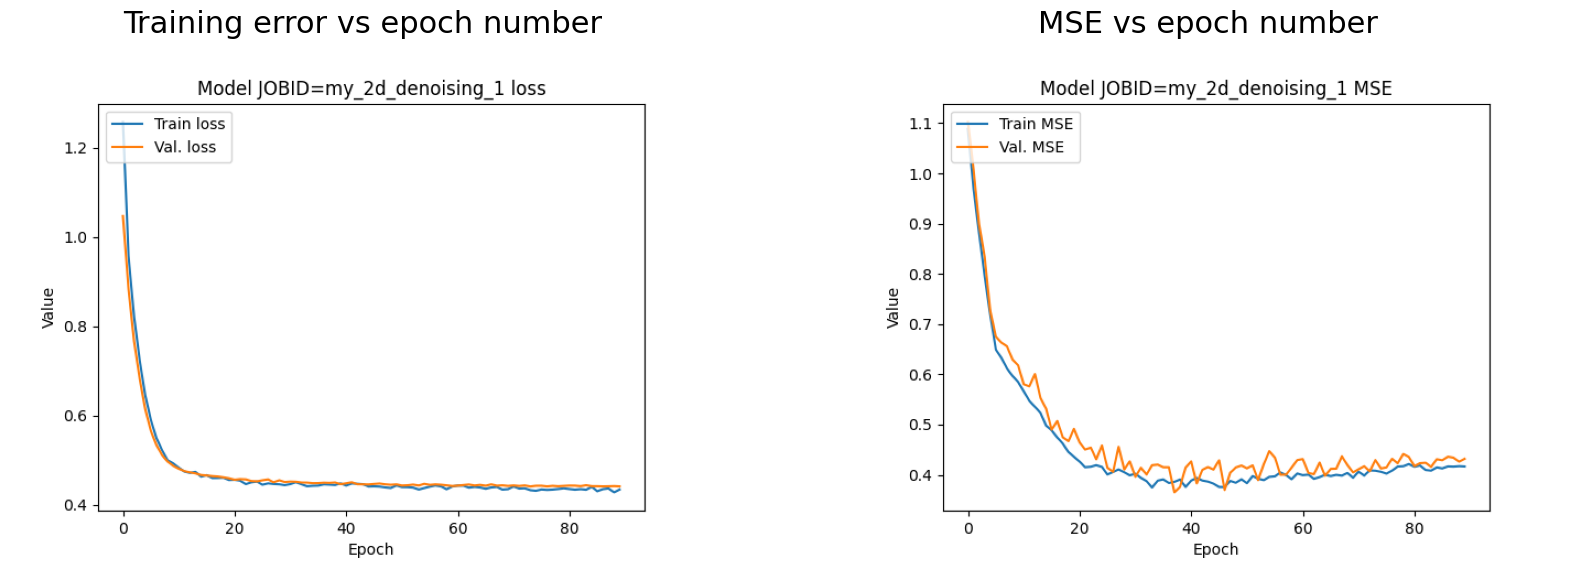

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and MSE vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_MSE.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'MSE vs epoch number', fontdict = {'fontsize':22})

## **Visualize denoising results**

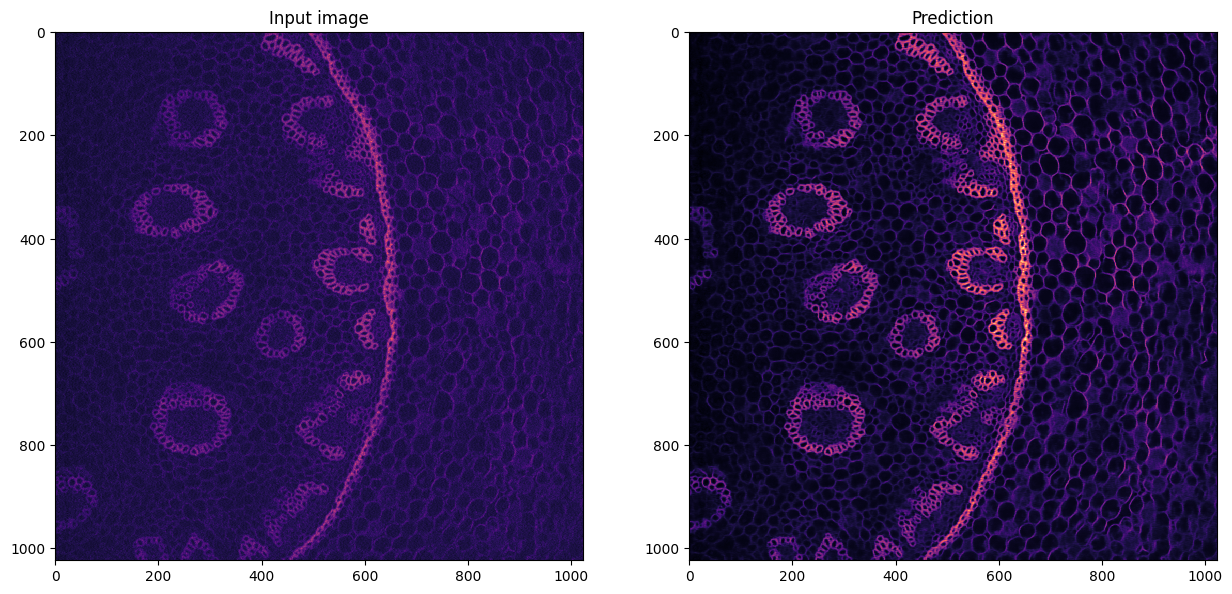

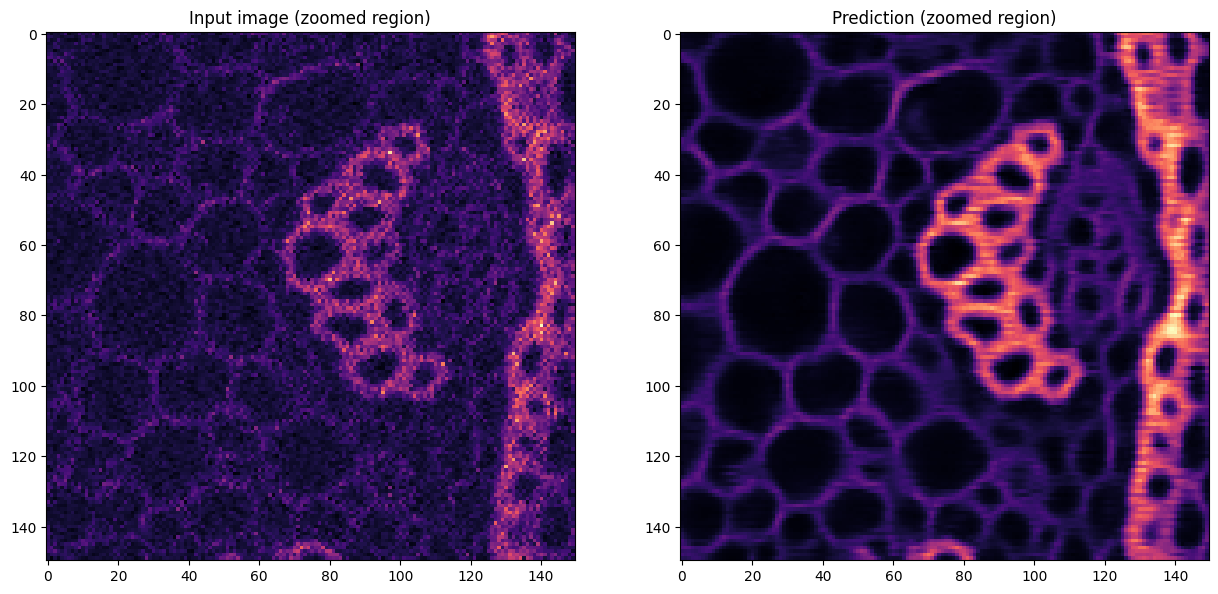

In [ ]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

if biapy_config['TEST']['STATS']['FULL_IMG'] == True:
    denoising_results = os.path.join(final_results, "full_image")
else:
    denoising_results = os.path.join(final_results, "per_image")

#@markdown ###Play to visualize some results
from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(denoising_results))[2])
ids_input = sorted(next(os.walk(test_data_path))[2])

samples_to_show = min(len(ids_input), 1)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(denoising_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

# Show predicted images
plt.figure(figsize=(15,15))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 2, index)
    plt.title("Input image")
    plt.imshow(test_samples[j], cmap='magma')

    index = index + 1
    plt.subplot(samples_to_show, 2, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap='magma', interpolation='nearest')

plt.show()

plt.figure(figsize=(15,15))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 2, index)
    plt.title("Input image (zoomed region)")

    tiny_patch = min(test_samples[j].shape[0],test_samples[j].shape[0]//2+150)
    tiny_patch2 = min(test_samples[j].shape[1],test_samples[j].shape[1]//2+150)
    plt.imshow(test_samples[j][
        test_samples[j].shape[0]//2:tiny_patch,
        test_samples[j].shape[1]//2:tiny_patch2
    ], cmap='magma')

    index = index + 1
    plt.subplot(samples_to_show, 2, index)
    plt.title("Prediction (zoomed region)")
    plt.imshow(test_sample_preds[j][
        test_sample_preds[j].shape[0]//2:tiny_patch,
        test_sample_preds[j].shape[1]//2:tiny_patch2
    ], cmap='magma')

plt.show()

In [ ]:
#@markdown ###Play to display the path to the output denoised files

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

denoising_results = os.path.join(final_results, "per_image")

print("Output paths:")
print("    Predicted test denoised images are in {}".format(denoising_results))

[17:24:32.680643] Output paths:
[17:24:32.681155]     Predicted test denoised images are in /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image


## **Download denoising results**

In [ ]:
#@markdown ###Play to download all denoising results in test.

from google.colab import files


!zip -q -j /content/denoising.zip $denoising_results/*.tif

files.download("/content/denoising.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Export your model to BioImage Model Zoo format:**

If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [ ]:
# ------------- User input ------------
# information about the model
#@markdown ##Introduce the metadata of the model architecture to export the model to BioImage Model Zoo format:
export_bioimage_model_zoo = False #@param {type:"boolean"}
trained_model_name    = "" #@param {type:"string"}
trained_model_authors =  "[First Author, Second Author, Third Author]" #@param {type:"string"}
trained_model_authors_affiliation =  "[First Author Affiliation, Second Author Affiliation, Third Author Affiliation]" #@param {type:"string"}
trained_model_description = "" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = ["Ronneberger et al. arXiv in 2015", "Franco-Barranco, Daniel, et al. ISBI in 2023"] #@param {type:"string"}
trained_model_references_DOI = ["10.1007/978-3-319-24574-4_28","10.1109/ISBI53787.2023.10230593"] #@param {type:"string"}
trained_model_tags = "modality: electron-microscopy, content: mitochondria" #@param {type:"string"}
trained_model_documentation = "/content/README.md" #@param {type:"string"}


In [ ]:
#@markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model
# update BMZ export parameters
from google.colab import files

if export_bioimage_model_zoo:
    # create the author spec input
    auth_names = trained_model_authors[1:-1].split(",")
    auth_affs = trained_model_authors_affiliation[1:-1].split(",")
    assert len(auth_names) == len(auth_affs)
    authors = [{"name": auth_name, "affiliation": auth_aff} for auth_name, auth_aff in zip(auth_names, auth_affs)]

    # create the citation input spec
    assert len(trained_model_references_DOI) == len(trained_model_references)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(trained_model_references, trained_model_references_DOI)]

    tags = [{t.split(":")[0]: t.split(":")[1]} for t in trained_model_tags.split(",")]

    with open(trained_model_documentation, "w") as f:
        f.write("### **Description**\n")
        f.write(f"{trained_model_description}\n\n")
        f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")


    final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
    bmz_results = os.path.join(final_results, "bmz_model")


    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Gizmo"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=[{'modality': 'electron-microscopy', 'content': 'mitochondria'}]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    bmz_cfg['doc'] = trained_model_documentation
    bmz_cfg['build_dir'] = bmz_results

    biapy.export_model_to_bmz(bmz_cfg)


    bmz_zip_path = f"/content/{trained_model_name}.bmz.zip"
    if os.path.isdir(bmz_results):
        !zip -r $bmz_zip_path $bmz_results
    else:
        print("The model was not exported to this format")

    files.download(bmz_zip_path)

## **Acknowledgments**

We extend our gratitude to the [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for their invaluable inspiration. Notably, we have adopted some of their descriptions concerning metrics and parameters.